In [1]:
import ipywidgets as widgets
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
from HARK.utilities import plot_funcs

import math
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from pprint import pprint

from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve

In [2]:
from HARK.ConsumptionSaving.ConsPortfolioModel import init_portfolio

In [3]:
init_portfolio

{'cycles': 1,
 'CRRA': 5.0,
 'Rfree': 1.03,
 'DiscFac': 0.9,
 'LivPrb': [0.98],
 'PermGroFac': [1.01],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 10000,
 'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'PerfMITShk': False,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 'UnempPrb': 0.05,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'neutral_measure': False,
 'NewbornTransShk': False,
 'RiskyAvg': 1.08,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

In [4]:
def interp_func(x,y):
    def func(z):
        return np.interp(z, x, y)
    
    return func

In [5]:
at = SequentialPortfolioConsumerType(PermGroFac=[1.0], UnempPrb=0.00)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

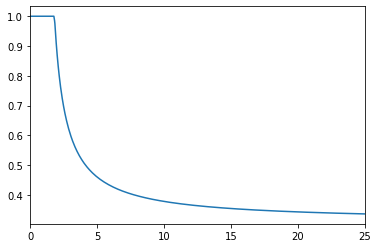

In [6]:
plot_funcs(ShareFunc, 0, 25)

In [7]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983


def price_dividend_ratio_random_walk(DiscFac, CRRA, days_per_quarter=90):
    # Assuming DiscFac in argument in quarterly
    DiscFac_daily = DiscFac ** (1.0 / days_per_quarter)

    dividend_shock_std = dividend_std / math.sqrt(dividend_growth_rate)

    subjective_return = (
        dividend_growth_rate ** (1 - CRRA)
        * DiscFac_daily
        * (dividend_shock_std**2 + 1) ** (CRRA * (CRRA - 1) / 2)
    )

    print("subjective_return: " + str(subjective_return))
    return subjective_return < 1

In [8]:
def compute_target_wealth(
    CRRA=6.0,
    DiscFac=0.9,
    RiskyAvg=1.08,
    RiskyStd=0.20,
    PermShkStd=[0.0],
    PermGroFac=[1.0001],
    UnempPrb=0.00
):
    agent_parameters = {}

    agent_parameters["CRRA"] = CRRA
    agent_parameters["DiscFac"] = DiscFac
    agent_parameters["RiskyAvg"] = RiskyAvg
    agent_parameters["RiskyStd"] = RiskyStd
    agent_parameters["PermShkStd"] = PermShkStd
    agent_parameters["PermGroFac"] = PermGroFac
    agent_parameters["UnempPrb"] = UnempPrb
    
    agent = SequentialPortfolioConsumerType(**agent_parameters)
    #pprint(agent.parameters)
    
    linear_roots, log_linear_roots, cubic_spline_roots = [], [], []
    
    try:
        agent.solve()
        solved = True
    except Exception as e:
        solved = False
        
        return solved, linear_roots, log_linear_roots, cubic_spline_roots
        

    ## subjective return
    srle1 = price_dividend_ratio_random_walk(DiscFac, CRRA)
    print("subjective_return < 1?: " + str(srle1))

    cFunc = agent.solution[0].cFuncAdj
    ShareFunc = agent.solution[0].ShareFuncAdj

    def expected_increase(ShareFunc, cFunc, mNrm):
        share = ShareFunc(mNrm)
        aNrm = mNrm - cFunc(mNrm)

        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1
        )

        gain = mNrm_next - aNrm
        return gain

    def expected_m_next(mNrm):
        share = ShareFunc(mNrm)
        aNrm = mNrm - cFunc(mNrm)
        mNrm_next = (
            aNrm
            * (
                share * agent.parameters["RiskyAvg"]
                + (1 - share) * agent.parameters["Rfree"]
            )
            + 1
        )

        return mNrm_next

    mNrm = np.linspace(0, 5, 1000)

    # plt.plot(mNrm, cFunc(mNrm), label="c")

    plt.plot(mNrm, mNrm - expected_m_next(mNrm), label="m - E[m']")

    linear_roots = fsolve(interp_func(mNrm, mNrm - expected_m_next(mNrm)), [mNrm[0]])
    log_linear_roots = np.log(fsolve(interp_func(mNrm, mNrm - expected_m_next(mNrm)), [mNrm[0]]))
    cubic_spline_roots = CubicSpline(mNrm,  mNrm - expected_m_next(mNrm)).roots()
    print(f"m - E[m] linear interp roots: {linear_roots}")
    print(f"m - E[m] log roots: {log_linear_roots}")
    print(f"m - E[m] CubicSpine roots: {cubic_spline_roots}")

    plt.plot(mNrm, np.zeros_like(mNrm), label="0")

    # plt.plot(mNrm, (mNrm - cFunc(mNrm)) * ShareFunc(mNrm), label ="wealth-into-market" )

    plt.legend()
    
    return solved, linear_roots, log_linear_roots, cubic_spline_roots

subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.02372074]
m - E[m] log roots: [0.02344378]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.02372043e+00]


(True,
 array([1.02372074]),
 array([0.02344378]),
 array([-1.93921018e+05,  1.02372043e+00]))

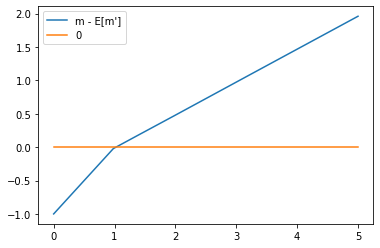

In [9]:
compute_target_wealth()

In [10]:
CRRA_grid = [2.0, 4.0, 6.0]
DiscFac_grid = [0.9, 0.95, 0.975]
RiskyAvg_grid = [1.08]
RiskyStd_grid = [0.20]
PermShkStd_grid =[0.0, 0.01, 0.1]
PermGroFac_grid =[1.0, 1.001, 1.1]
UnempPrb_grid= [0.00, 0.001, 0.1]

subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  9.99995150e-01  2.91333916e+04]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00004270e+00  1.62662898e+04]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.17413511]
m - E[m] log roots: [0.1605318]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.17413511e+00  1.01660764e+01]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  9.99988779e-01  5.84869876e+04]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+0

/home/sb/projects/ufm/SHARKFin/sharkfin-env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.00264135]
m - E[m] log roots: [0.00263787]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00261179e+00]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.00665043]
m - E[m] log roots: [0.00662841]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00664539e+00  1.73304278e+04]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.17984737]
m - E[m] log roots: [0.16538508]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.17984737e+00  6.04092358e+00]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00000000e+00  6.75374932e+00]
subjective_return: 0.9987706573085862
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots

subjective_return: 0.9996593225093474
subjective_return < 1?: True
m - E[m] linear interp roots: [1.14803975]
m - E[m] log roots: [0.13805592]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.14803974e+00]
subjective_return: 0.9996593225093474
subjective_return < 1?: True
m - E[m] linear interp roots: [1.03087744]
m - E[m] log roots: [0.03041032]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03087744e+00]
subjective_return: 0.9996593225093474
subjective_return < 1?: True
m - E[m] linear interp roots: [1.03455007]
m - E[m] log roots: [0.03396662]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03455005e+00  9.55352121e+03]
subjective_return: 0.9996593225093474
subjective_return < 1?: True
m - E[m] linear interp roots: [1.2060163]
m - E[m] log roots: [0.18732262]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.20601631e+00  1.21825539e+04]
subjective_return: 0.9996593225093474
subjective_return < 1?: True
m - E[m] linear interp roots: [1.02985547]
m - E[m] log roots: [0.02941847]
m - E[m] C

subjective_return: 0.9990821279602972
subjective_return < 1?: True
m - E[m] linear interp roots: [1.04932169]
m - E[m] log roots: [0.04814394]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.04932318e+00  1.57241256e+02]
subjective_return: 0.9990821279602972
subjective_return < 1?: True
m - E[m] linear interp roots: [1.31905689]
m - E[m] log roots: [0.27691701]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.31905676e+00]
subjective_return: 0.9990821279602972
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00000000e+00  1.68096837e+05]
subjective_return: 0.9990821279602972
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.00000001e+00  2.35085754e+05]
subjective_return: 0.9990821279602972
subjective_return < 1?: True
m - E[m] linear interp roots: [1.27959226]
m - E[m] log roots: [0.24654148]
m - E[m] CubicSpine roots

subjective_return: 0.9999710702948802
subjective_return < 1?: True
m - E[m] linear interp roots: [1.0317756]
m - E[m] log roots: [0.0312812]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03177556e+00  5.62569092e+05]
subjective_return: 0.9999710702948802
subjective_return < 1?: True
m - E[m] linear interp roots: [1.04981354]
m - E[m] log roots: [0.04861257]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.04981385e+00  3.38149864e+05]
subjective_return: 0.9999710702948802
subjective_return < 1?: True
m - E[m] linear interp roots: [1.32907931]
m - E[m] log roots: [0.28448645]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.32907941e+00]
subjective_return: 0.9999710702948802
subjective_return < 1?: True
m - E[m] linear interp roots: [1.03076974]
m - E[m] log roots: [0.03030585]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03076974e+00  4.50652333e+05]
subjective_return: 0.9999710702948802
subjective_return < 1?: True
m - E[m] linear interp roots: [1.04894505]
m - E[m] log roots: [0.04778

subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.0524699]
m - E[m] log roots: [0.05113969]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.05246837e+00]
subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.10314069]
m - E[m] log roots: [0.09816128]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.10314126e+00  1.14720571e+05]
subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.40695562]
m - E[m] log roots: [0.34142823]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.40695526e+00]
subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.]
m - E[m] log roots: [0.]
m - E[m] CubicSpine roots: [-1.93921018e+05  9.99999999e-01  3.39276643e+06]
subjective_return: 0.9999677237554393
subjective_return < 1?: True
m - E[m] linear interp roots: [1.0463153]
m - E[m] log roots: [0.04527475]
m - E[m] CubicSpine roots: 

subjective_return: 1.0008574540568687
subjective_return < 1?: False
m - E[m] linear interp roots: [1.03752783]
m - E[m] log roots: [0.03684079]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03752783e+00  6.80885379e+00]
subjective_return: 1.0008574540568687
subjective_return < 1?: False
m - E[m] linear interp roots: [1.37803373]
m - E[m] log roots: [0.32065765]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.37803366e+00]
subjective_return: 1.0008574540568687
subjective_return < 1?: False
m - E[m] linear interp roots: [1.03778225]
m - E[m] log roots: [0.03708598]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.03778225e+00]
subjective_return: 1.0008574540568687
subjective_return < 1?: False
m - E[m] linear interp roots: [1.09599438]
m - E[m] log roots: [0.09166206]
m - E[m] CubicSpine roots: [-1.93921018e+05  1.09599438e+00  1.25024814e+05]
subjective_return: 1.0008574540568687
subjective_return < 1?: False
m - E[m] linear interp roots: [1.41237704]
m - E[m] log roots: [0.34527413]
m - 

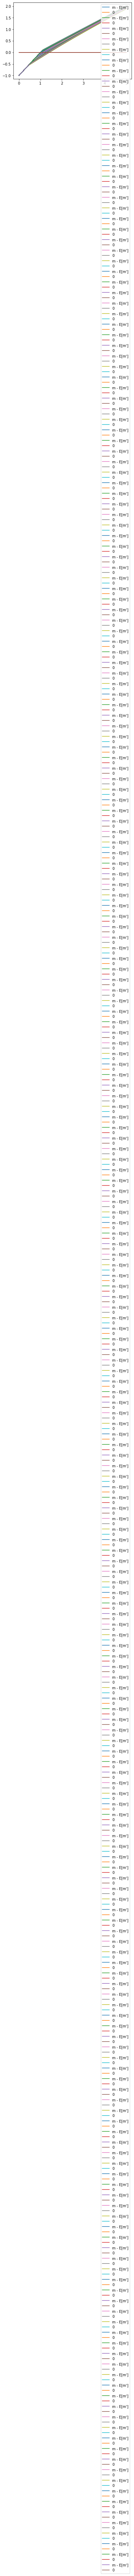

In [11]:
rows = []

for CRRA in CRRA_grid:
    for DiscFac in DiscFac_grid:
        for RiskyAvg in RiskyAvg_grid:
            for RiskyStd in RiskyStd_grid:
                for PermShkStd in PermShkStd_grid:
                    for PermGroFac in PermGroFac_grid:
                        for UnempPrb in UnempPrb_grid:
                            s, lr, llr, csr = compute_target_wealth(
                                CRRA=CRRA,
                                DiscFac=DiscFac,
                                RiskyAvg=RiskyAvg,
                                RiskyStd=RiskyStd,
                                PermShkStd=[PermShkStd],
                                PermGroFac=[PermGroFac],
                                UnempPrb=UnempPrb
                            )
                            
                            rows.append({
                                'CRRA' : CRRA,
                                'DiscFac' : DiscFac,
                                'RiskyAvg' : RiskyAvg,
                                'RiskyStd' : RiskyStd,
                                'PermShkStd' : PermShkStd,
                                'PermGroFac' : PermGroFac,
                                'UnempPrb' : UnempPrb,
                                'solved' : s,
                                'linear root' : lr,
                            })



In [12]:
df = pd.DataFrame(rows)

In [13]:
df.to_csv('roots.csv')

In [14]:
df.corr()

/tmp/ipykernel_23404/1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,PermGroFac,UnempPrb,solved
CRRA,1.000000e+00,2.770408e-16,NaN,NaN,2.861956e-16,2.809359e-15,-2.027987e-16,NaN
DiscFac,2.770408e-16,1.000000e+00,NaN,NaN,3.996653e-16,-1.989004e-16,-8.541733e-17,NaN
RiskyAvg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RiskyStd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PermShkStd,2.861956e-16,3.996653e-16,NaN,NaN,1.000000e+00,2.453659e-16,-1.015307e-17,NaN
PermGroFac,2.809359e-15,-1.989004e-16,NaN,NaN,2.453659e-16,1.000000e+00,-2.757886e-17,NaN
UnempPrb,-2.027987e-16,-8.541733e-17,NaN,NaN,-1.015307e-17,-2.757886e-17,1.000000e+00,NaN
solved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
list(df[~df['solved']]['PermGroFac'])

In [18]:
df['solved'].sum()

243

In [19]:
df

,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,PermGroFac,UnempPrb,solved,linear root
0,2.0,0.900,1.08,0.2,0.0,1.000,0.000,True,[1.0]
1,2.0,0.900,1.08,0.2,0.0,1.000,0.001,True,[1.0]
2,2.0,0.900,1.08,0.2,0.0,1.000,0.100,True,[1.1741351124225394]
3,2.0,0.900,1.08,0.2,0.0,1.001,0.000,True,[1.0]
4,2.0,0.900,1.08,0.2,0.0,1.001,0.001,True,[1.0]
...,...,...,...,...,...,...,...,...,...
238,6.0,0.975,1.08,0.2,0.1,1.001,0.001,True,[1.113461564174906]
239,6.0,0.975,1.08,0.2,0.1,1.001,0.100,True,[1.4172742386048491]
240,6.0,0.975,1.08,0.2,0.1,1.100,0.000,True,[1.0]
241,6.0,0.975,1.08,0.2,0.1,1.100,0.001,True,[1.0545030980564383]
